# About this notebook
- PyTorch efficientnet_b0 with W&B starter code
- Pytorch W&B Usage Examples from https://docs.wandb.ai/guides/integrations/pytorch

If this notebook is helpful, feel free to upvote :)

![](https://www.petfinder.my/images/cuteness_meter.jpg)

In [1]:
!pip install -q --upgrade wandb
!pip install -q grad-cam
!pip install -q ttach

# Data Loading

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

def get_train_file_path(image_id):
    return "../input/petfinder-pawpularity-score/train/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


# Quick EDA

<AxesSubplot:>

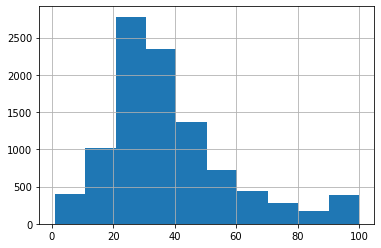

In [4]:
train['Pawpularity'].hist()

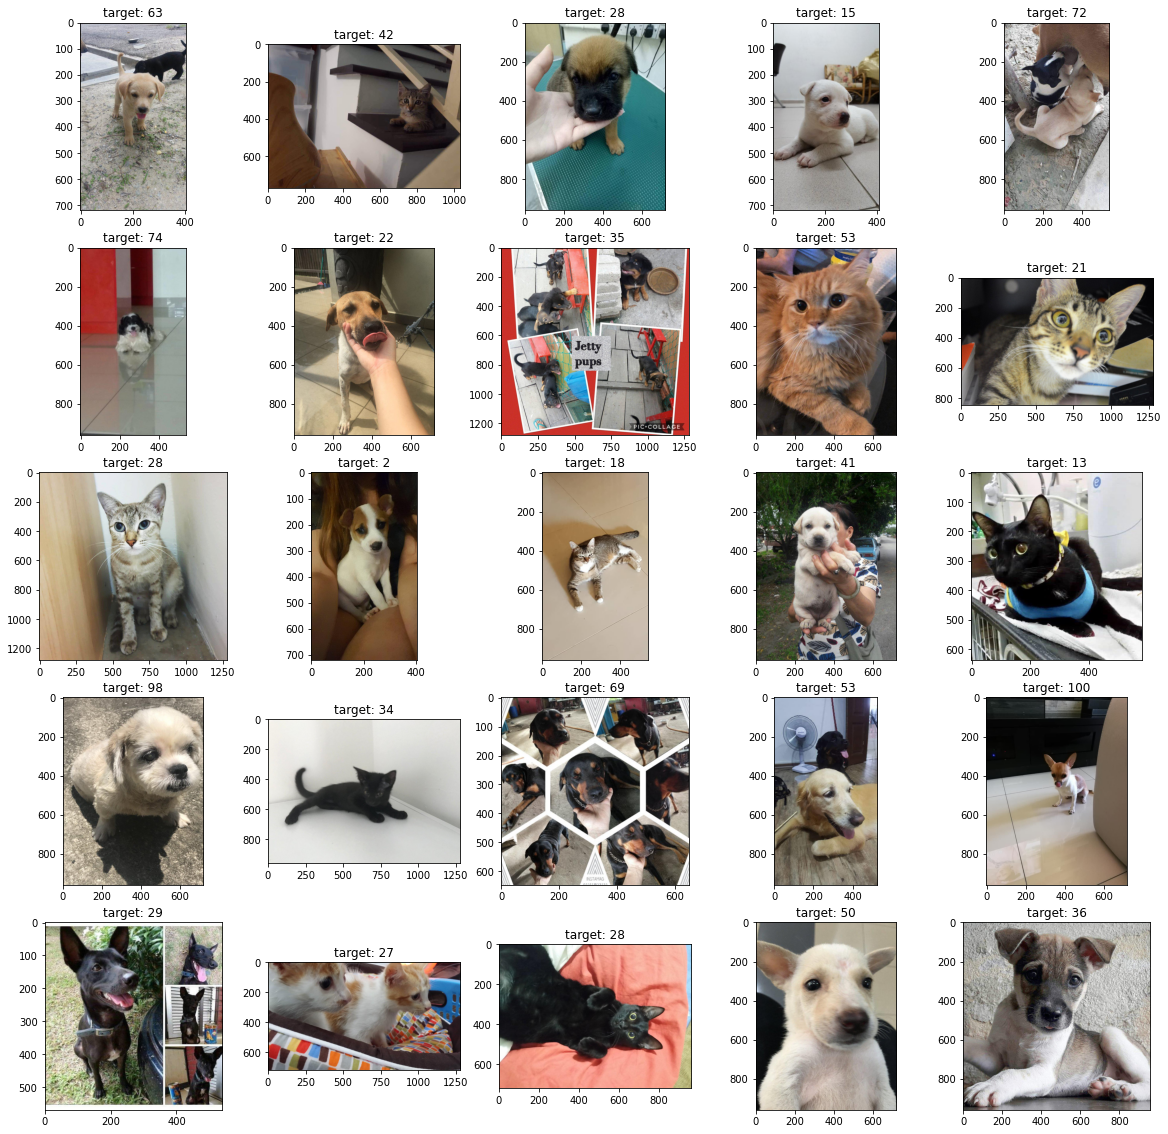

In [5]:
plt.figure(figsize=(20, 20))
row, col = 5, 5
for i in range(row * col):
    plt.subplot(col, row, i+1)
    image = cv2.imread(train.loc[i, 'file_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train.loc[i, 'Pawpularity']
    plt.imshow(image)
    plt.title(f"target: {target}")
plt.show()

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=True
    debug=False
    print_freq=10
    num_workers=4
    size=384
    model_name='eca_nfnet_l2'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=5
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=4 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-7
    batch_size=32
    weight_decay=1e-7
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=False
    mix_up=True
    cut_mix=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, Optimizer, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# ====================================================
# wandb
# ====================================================
wandb_api = "ad185fc040cf022e94161aaabaa8caec07cbb174"

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="pet", 
                 entity='mizoo',
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mizoo (use `wandb login --relogin` to force relogin)
2021-11-30 23:36:36.618163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [11]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0        66
      1        84
      2       221
      3       406
      4       376
             ... 
4     9        55
      10       40
      11       28
      12       21
      13       72
Length: 70, dtype: int64

In [12]:
train.to_pickle(OUTPUT_DIR+'train.pkl')

# Dataset

In [13]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

    
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['Id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        vis_image = cv2.resize(image, (CFG.size, CFG.size)).copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [14]:
# =================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0, p=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.0, p=1.0),
                A.ElasticTransform(alpha=3, p=1.0),
            ], p=0.2),
            A.Cutout(p=0.3),
            A.ColorJitter(p=0.3),
            A.IAASharpen(p=0.25),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

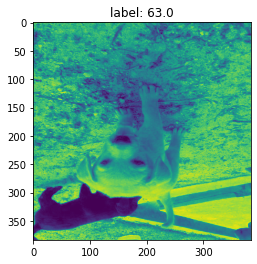

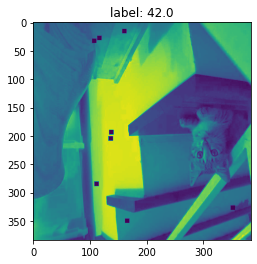

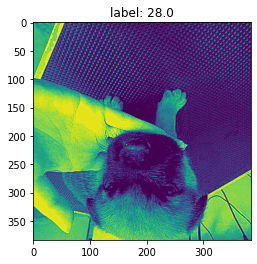

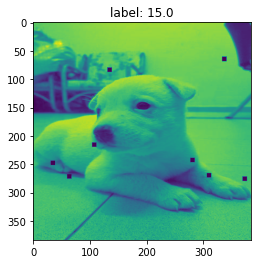

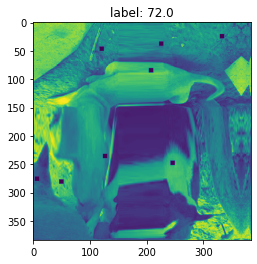

In [15]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        if  "eff" in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif "mixer" in self.cfg.model_name:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Identity()
        elif "resnest" in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif "nfnet" in self.cfg.model_name:
            self.n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Identity()
        else:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# Loss

In [17]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Helper functions

In [18]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().to(device) / 100.0
        batch_size = labels.size(0)
        if CFG.mix_up:
            inputs1, targets_a, targets_b, lam = mixup_data(images, labels.view(-1, 1), use_cuda=True)

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        elif CFG.cut_mix:
            inputs1, targets_a, targets_b, lam = cutmix(images, labels.view(-1, 1))

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            if CFG.apex:
                with autocast():
                    y_preds = model(images)
                    loss = criterion(y_preds.view(-1), labels)
            else:
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.float().to(device) / 100.0
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().detach().cpu() * 100.0)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [21]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    result = {"vis": None, "img": None, "pred": None, "label": None}
    with torch.no_grad():
        pred = model(x_tensor.unsqueeze(0).to(device))
    pred = np.concatenate(pred.to('cpu').numpy())[0]
    target_layer = model.model.conv_head
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    output = cam(input_tensor=x_tensor.unsqueeze(0).to(device))
    try:
        vis = show_cam_on_image(img / 255., output[0])
    except:
        return result
    if plot:
        fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"pred={pred:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
    result = {"vis": vis, "img": img, "pred": pred, "label": label}
    torch.cuda.empty_cache()
    return result

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    #model = replace_activations(model, torch.nn.SiLU, Mish())
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.grad_cam:
        wandb_table = wandb.Table(columns=["Id", "Pawpularity", "pred", "image", "grad_cam_image"])
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                # load model
                model = CustomModel(CFG, pretrained=False)
                state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                   map_location=torch.device('cpu'))['model']
                model.load_state_dict(state)
                model.to(device)
                model.eval()
                # load oof
                oof = pd.read_csv(OUTPUT_DIR+'oof_df.csv')
                oof['diff'] = abs(oof['Pawpularity'] - oof['preds'])
                oof = oof[oof['fold'] == fold].reset_index(drop=True)
                # grad-cam (oof ascending=False)
                count = 0
                oof = oof.sort_values('diff', ascending=False)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["pred"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= 5:
                        break
                # grad-cam (oof ascending=True)
                count = 0
                oof = oof.sort_values('diff', ascending=True)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["pred"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= 5:
                        break
        wandb.log({'grad_cam': wandb_table})
    
    wandb.finish()

In [24]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l2_ra3-da781a61.pth" to /root/.cache/torch/hub/checkpoints/ecanfnet_l2_ra3-da781a61.pth


Epoch: [1][0/247] Elapsed 0m 6s (remain 27m 4s) Loss: 0.6931(0.6931) Grad: 0.6477  LR: 0.000100  
Epoch: [1][10/247] Elapsed 0m 28s (remain 10m 20s) Loss: 0.6600(0.6699) Grad: 0.3352  LR: 0.000100  
Epoch: [1][20/247] Elapsed 0m 51s (remain 9m 10s) Loss: 0.6659(0.6667) Grad: 0.2935  LR: 0.000100  
Epoch: [1][30/247] Elapsed 1m 13s (remain 8m 32s) Loss: 0.6645(0.6666) Grad: 0.2579  LR: 0.000100  
Epoch: [1][40/247] Elapsed 1m 35s (remain 8m 2s) Loss: 0.6529(0.6653) Grad: 0.2488  LR: 0.000100  
Epoch: [1][50/247] Elapsed 1m 58s (remain 7m 34s) Loss: 0.6396(0.6648) Grad: 0.2509  LR: 0.000100  
Epoch: [1][60/247] Elapsed 2m 20s (remain 7m 8s) Loss: 0.6412(0.6630) Grad: 0.4199  LR: 0.000100  
Epoch: [1][70/247] Elapsed 2m 42s (remain 6m 43s) Loss: 0.6573(0.6616) Grad: 0.2759  LR: 0.000100  
Epoch: [1][80/247] Elapsed 3m 5s (remain 6m 19s) Loss: 0.6404(0.6611) Grad: 0.1970  LR: 0.000100  
Epoch: [1][90/247] Elapsed 3m 27s (remain 5m 55s) Loss: 0.6686(0.6609) Grad: 0.2677  LR: 0.000100  
Epoc

Epoch 1 - avg_train_loss: 0.6561  avg_val_loss: 0.6491  time: 651s
Epoch 1 - Score: 18.7808
Epoch 1 - Save Best Score: 18.7808 Model


EVAL: [30/31] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6545(0.6491) 
Epoch: [2][0/247] Elapsed 0m 5s (remain 20m 40s) Loss: 0.6765(0.6765) Grad: 0.3198  LR: 0.000073  
Epoch: [2][10/247] Elapsed 0m 27s (remain 9m 52s) Loss: 0.6460(0.6601) Grad: 0.3330  LR: 0.000073  
Epoch: [2][20/247] Elapsed 0m 49s (remain 8m 57s) Loss: 0.6016(0.6469) Grad: 0.0880  LR: 0.000073  
Epoch: [2][30/247] Elapsed 1m 12s (remain 8m 23s) Loss: 0.6156(0.6437) Grad: 0.3513  LR: 0.000073  
Epoch: [2][40/247] Elapsed 1m 34s (remain 7m 55s) Loss: 0.6432(0.6453) Grad: 0.1219  LR: 0.000073  
Epoch: [2][50/247] Elapsed 1m 56s (remain 7m 29s) Loss: 0.6355(0.6473) Grad: 0.1725  LR: 0.000073  
Epoch: [2][60/247] Elapsed 2m 19s (remain 7m 4s) Loss: 0.6314(0.6486) Grad: 0.1839  LR: 0.000073  
Epoch: [2][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6459(0.6478) Grad: 0.1959  LR: 0.000073  
Epoch: [2][80/247] Elapsed 3m 4s (remain 6m 17s) Loss: 0.6513(0.6498) Grad: 0.3707  LR: 0.000073  
Epoch: [2][90/247] Elapsed 3m 26s (re

Epoch 2 - avg_train_loss: 0.6504  avg_val_loss: 0.6466  time: 647s
Epoch 2 - Score: 18.4250
Epoch 2 - Save Best Score: 18.4250 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6661(0.6466) 
Epoch: [3][0/247] Elapsed 0m 7s (remain 29m 33s) Loss: 0.6111(0.6111) Grad: 0.1347  LR: 0.000029  
Epoch: [3][10/247] Elapsed 0m 29s (remain 10m 33s) Loss: 0.6324(0.6529) Grad: 0.1892  LR: 0.000029  
Epoch: [3][20/247] Elapsed 0m 51s (remain 9m 17s) Loss: 0.6278(0.6471) Grad: 0.3557  LR: 0.000029  
Epoch: [3][30/247] Elapsed 1m 14s (remain 8m 36s) Loss: 0.6651(0.6468) Grad: 0.3103  LR: 0.000029  
Epoch: [3][40/247] Elapsed 1m 36s (remain 8m 4s) Loss: 0.6649(0.6445) Grad: 0.3492  LR: 0.000029  
Epoch: [3][50/247] Elapsed 1m 58s (remain 7m 36s) Loss: 0.6646(0.6452) Grad: 0.2424  LR: 0.000029  
Epoch: [3][60/247] Elapsed 2m 21s (remain 7m 10s) Loss: 0.6464(0.6455) Grad: 0.2860  LR: 0.000029  
Epoch: [3][70/247] Elapsed 2m 43s (remain 6m 44s) Loss: 0.6437(0.6464) Grad: 0.2659  LR: 0.000029  
Epoch: [3][80/247] Elapsed 3m 5s (remain 6m 20s) Loss: 0.6598(0.6461) Grad: 0.2800  LR: 0.000029  
Epoch: [3][90/247] Elapsed 3m 27s (r

Epoch 3 - avg_train_loss: 0.6443  avg_val_loss: 0.6461  time: 648s
Epoch 3 - Score: 18.4004
Epoch 3 - Save Best Score: 18.4004 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6580(0.6461) 
Epoch: [4][0/247] Elapsed 0m 5s (remain 22m 57s) Loss: 0.6625(0.6625) Grad: 0.1679  LR: 0.000004  
Epoch: [4][10/247] Elapsed 0m 28s (remain 10m 3s) Loss: 0.6111(0.6381) Grad: 0.2176  LR: 0.000004  
Epoch: [4][20/247] Elapsed 0m 50s (remain 9m 2s) Loss: 0.6611(0.6357) Grad: 0.2030  LR: 0.000004  
Epoch: [4][30/247] Elapsed 1m 12s (remain 8m 27s) Loss: 0.6395(0.6354) Grad: 0.1348  LR: 0.000004  
Epoch: [4][40/247] Elapsed 1m 35s (remain 7m 58s) Loss: 0.6286(0.6346) Grad: 0.1904  LR: 0.000004  
Epoch: [4][50/247] Elapsed 1m 57s (remain 7m 31s) Loss: 0.6728(0.6344) Grad: 0.2551  LR: 0.000004  
Epoch: [4][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6199(0.6346) Grad: 0.2467  LR: 0.000004  
Epoch: [4][70/247] Elapsed 2m 42s (remain 6m 42s) Loss: 0.6580(0.6362) Grad: 0.1829  LR: 0.000004  
Epoch: [4][80/247] Elapsed 3m 4s (remain 6m 18s) Loss: 0.6367(0.6360) Grad: 0.2274  LR: 0.000004  
Epoch: [4][90/247] Elapsed 3m 27s (rem

Epoch 4 - avg_train_loss: 0.6361  avg_val_loss: 0.6448  time: 648s
Epoch 4 - Score: 18.2243
Epoch 4 - Save Best Score: 18.2243 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6666(0.6448) 
Epoch: [5][0/247] Elapsed 0m 5s (remain 24m 35s) Loss: 0.6225(0.6225) Grad: 0.2258  LR: 0.000000  
Epoch: [5][10/247] Elapsed 0m 28s (remain 10m 14s) Loss: 0.6403(0.6413) Grad: 0.1794  LR: 0.000000  
Epoch: [5][20/247] Elapsed 0m 51s (remain 9m 9s) Loss: 0.6047(0.6316) Grad: 0.2593  LR: 0.000000  
Epoch: [5][30/247] Elapsed 1m 13s (remain 8m 30s) Loss: 0.6211(0.6306) Grad: 0.2392  LR: 0.000000  
Epoch: [5][40/247] Elapsed 1m 35s (remain 8m 0s) Loss: 0.6619(0.6334) Grad: 0.3041  LR: 0.000000  
Epoch: [5][50/247] Elapsed 1m 57s (remain 7m 33s) Loss: 0.6397(0.6345) Grad: 0.1694  LR: 0.000000  
Epoch: [5][60/247] Elapsed 2m 20s (remain 7m 8s) Loss: 0.6122(0.6330) Grad: 0.2263  LR: 0.000000  
Epoch: [5][70/247] Elapsed 2m 42s (remain 6m 43s) Loss: 0.6364(0.6329) Grad: 0.2160  LR: 0.000000  
Epoch: [5][80/247] Elapsed 3m 5s (remain 6m 19s) Loss: 0.6536(0.6339) Grad: 0.1735  LR: 0.000000  
Epoch: [5][90/247] Elapsed 3m 27s (rem

Epoch 5 - avg_train_loss: 0.6344  avg_val_loss: 0.6444  time: 650s
Epoch 5 - Score: 18.1915
Epoch 5 - Save Best Score: 18.1915 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6649(0.6444) 


========== fold: 0 result ==========
Score: 18.1915
========== fold: 1 training ==========


Epoch: [1][0/247] Elapsed 0m 5s (remain 24m 25s) Loss: 0.6815(0.6815) Grad: 0.6190  LR: 0.000100  
Epoch: [1][10/247] Elapsed 0m 28s (remain 10m 8s) Loss: 0.6579(0.6590) Grad: 0.3312  LR: 0.000100  
Epoch: [1][20/247] Elapsed 0m 50s (remain 9m 5s) Loss: 0.6689(0.6632) Grad: 0.2977  LR: 0.000100  
Epoch: [1][30/247] Elapsed 1m 13s (remain 8m 29s) Loss: 0.6687(0.6600) Grad: 0.4217  LR: 0.000100  
Epoch: [1][40/247] Elapsed 1m 35s (remain 7m 59s) Loss: 0.6670(0.6597) Grad: 0.2496  LR: 0.000100  
Epoch: [1][50/247] Elapsed 1m 57s (remain 7m 33s) Loss: 0.6599(0.6601) Grad: 0.2586  LR: 0.000100  
Epoch: [1][60/247] Elapsed 2m 20s (remain 7m 7s) Loss: 0.6597(0.6588) Grad: 0.2380  LR: 0.000100  
Epoch: [1][70/247] Elapsed 2m 42s (remain 6m 43s) Loss: 0.6708(0.6600) Grad: 0.2094  LR: 0.000100  
Epoch: [1][80/247] Elapsed 3m 5s (remain 6m 19s) Loss: 0.6745(0.6607) Grad: 0.2485  LR: 0.000100  
Epoch: [1][90/247] Elapsed 3m 27s (remain 5m 55s) Loss: 0.6961(0.6600) Grad: 0.4954  LR: 0.000100  
Epoc

Epoch 1 - avg_train_loss: 0.6568  avg_val_loss: 0.6478  time: 649s
Epoch 1 - Score: 18.5491
Epoch 1 - Save Best Score: 18.5491 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6650(0.6478) 
Epoch: [2][0/247] Elapsed 0m 5s (remain 20m 59s) Loss: 0.6550(0.6550) Grad: 0.2983  LR: 0.000073  
Epoch: [2][10/247] Elapsed 0m 27s (remain 9m 54s) Loss: 0.6292(0.6458) Grad: 0.2185  LR: 0.000073  
Epoch: [2][20/247] Elapsed 0m 49s (remain 8m 58s) Loss: 0.6248(0.6419) Grad: 0.1442  LR: 0.000073  
Epoch: [2][30/247] Elapsed 1m 12s (remain 8m 23s) Loss: 0.6403(0.6431) Grad: 0.2809  LR: 0.000073  
Epoch: [2][40/247] Elapsed 1m 34s (remain 7m 55s) Loss: 0.6364(0.6440) Grad: 0.1663  LR: 0.000073  
Epoch: [2][50/247] Elapsed 1m 57s (remain 7m 29s) Loss: 0.6449(0.6448) Grad: 0.2164  LR: 0.000073  
Epoch: [2][60/247] Elapsed 2m 19s (remain 7m 5s) Loss: 0.6334(0.6439) Grad: 0.2124  LR: 0.000073  
Epoch: [2][70/247] Elapsed 2m 41s (remain 6m 41s) Loss: 0.6739(0.6450) Grad: 0.1278  LR: 0.000073  
Epoch: [2][80/247] Elapsed 3m 4s (remain 6m 17s) Loss: 0.6838(0.6456) Grad: 0.2935  LR: 0.000073  
Epoch: [2][90/247] Elapsed 3m 26s (re

Epoch 2 - avg_train_loss: 0.6491  avg_val_loss: 0.6513  time: 650s
Epoch 2 - Score: 18.9873


EVAL: [30/31] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6659(0.6513) 
Epoch: [3][0/247] Elapsed 0m 4s (remain 17m 58s) Loss: 0.6551(0.6551) Grad: 0.2168  LR: 0.000029  
Epoch: [3][10/247] Elapsed 0m 27s (remain 9m 40s) Loss: 0.6344(0.6431) Grad: 0.2213  LR: 0.000029  
Epoch: [3][20/247] Elapsed 0m 49s (remain 8m 51s) Loss: 0.6467(0.6449) Grad: 0.2646  LR: 0.000029  
Epoch: [3][30/247] Elapsed 1m 11s (remain 8m 20s) Loss: 0.6496(0.6428) Grad: 0.1561  LR: 0.000029  
Epoch: [3][40/247] Elapsed 1m 34s (remain 7m 53s) Loss: 0.6439(0.6442) Grad: 0.2754  LR: 0.000029  
Epoch: [3][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6471(0.6439) Grad: 0.2483  LR: 0.000029  
Epoch: [3][60/247] Elapsed 2m 19s (remain 7m 4s) Loss: 0.6647(0.6444) Grad: 0.1747  LR: 0.000029  
Epoch: [3][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6660(0.6443) Grad: 0.1859  LR: 0.000029  
Epoch: [3][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6123(0.6440) Grad: 0.2658  LR: 0.000029  
Epoch: [3][90/247] Elapsed 3m 26s (re

Epoch 3 - avg_train_loss: 0.6427  avg_val_loss: 0.6545  time: 649s
Epoch 3 - Score: 19.3578


EVAL: [30/31] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6700(0.6545) 
Epoch: [4][0/247] Elapsed 0m 5s (remain 20m 57s) Loss: 0.6701(0.6701) Grad: 0.1973  LR: 0.000004  
Epoch: [4][10/247] Elapsed 0m 27s (remain 9m 49s) Loss: 0.6130(0.6401) Grad: 0.2985  LR: 0.000004  
Epoch: [4][20/247] Elapsed 0m 49s (remain 8m 56s) Loss: 0.6263(0.6440) Grad: 0.2014  LR: 0.000004  
Epoch: [4][30/247] Elapsed 1m 12s (remain 8m 23s) Loss: 0.6349(0.6428) Grad: 0.2033  LR: 0.000004  
Epoch: [4][40/247] Elapsed 1m 34s (remain 7m 55s) Loss: 0.6489(0.6440) Grad: 0.1911  LR: 0.000004  
Epoch: [4][50/247] Elapsed 1m 56s (remain 7m 29s) Loss: 0.6661(0.6437) Grad: 0.2294  LR: 0.000004  
Epoch: [4][60/247] Elapsed 2m 19s (remain 7m 4s) Loss: 0.6333(0.6426) Grad: 0.1264  LR: 0.000004  
Epoch: [4][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6208(0.6413) Grad: 0.2395  LR: 0.000004  
Epoch: [4][80/247] Elapsed 3m 4s (remain 6m 17s) Loss: 0.6446(0.6411) Grad: 0.1881  LR: 0.000004  
Epoch: [4][90/247] Elapsed 3m 26s (re

Epoch 4 - avg_train_loss: 0.6370  avg_val_loss: 0.6486  time: 650s
Epoch 4 - Score: 18.5806


EVAL: [30/31] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6580(0.6486) 
Epoch: [5][0/247] Elapsed 0m 5s (remain 22m 51s) Loss: 0.6226(0.6226) Grad: 0.1573  LR: 0.000000  
Epoch: [5][10/247] Elapsed 0m 28s (remain 10m 2s) Loss: 0.6544(0.6312) Grad: 0.3031  LR: 0.000000  
Epoch: [5][20/247] Elapsed 0m 50s (remain 9m 2s) Loss: 0.6139(0.6343) Grad: 0.1917  LR: 0.000000  
Epoch: [5][30/247] Elapsed 1m 12s (remain 8m 28s) Loss: 0.5903(0.6301) Grad: 0.2837  LR: 0.000000  
Epoch: [5][40/247] Elapsed 1m 35s (remain 7m 58s) Loss: 0.6384(0.6314) Grad: 0.2187  LR: 0.000000  
Epoch: [5][50/247] Elapsed 1m 57s (remain 7m 32s) Loss: 0.6458(0.6323) Grad: 0.1679  LR: 0.000000  
Epoch: [5][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6364(0.6308) Grad: 0.2319  LR: 0.000000  
Epoch: [5][70/247] Elapsed 2m 42s (remain 6m 42s) Loss: 0.6470(0.6308) Grad: 0.2308  LR: 0.000000  
Epoch: [5][80/247] Elapsed 3m 4s (remain 6m 18s) Loss: 0.6573(0.6303) Grad: 0.2067  LR: 0.000000  
Epoch: [5][90/247] Elapsed 3m 27s (rem

Epoch 5 - avg_train_loss: 0.6306  avg_val_loss: 0.6485  time: 650s
Epoch 5 - Score: 18.5732


EVAL: [30/31] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6517(0.6485) 


========== fold: 1 result ==========
Score: 18.5491
========== fold: 2 training ==========


Epoch: [1][0/247] Elapsed 0m 6s (remain 24m 40s) Loss: 0.6883(0.6883) Grad: 0.6090  LR: 0.000100  
Epoch: [1][10/247] Elapsed 0m 28s (remain 10m 9s) Loss: 0.6326(0.6668) Grad: 0.2673  LR: 0.000100  
Epoch: [1][20/247] Elapsed 0m 50s (remain 9m 6s) Loss: 0.6735(0.6640) Grad: 0.2937  LR: 0.000100  
Epoch: [1][30/247] Elapsed 1m 13s (remain 8m 29s) Loss: 0.6293(0.6609) Grad: 0.2308  LR: 0.000100  
Epoch: [1][40/247] Elapsed 1m 35s (remain 7m 59s) Loss: 0.6544(0.6597) Grad: 0.2755  LR: 0.000100  
Epoch: [1][50/247] Elapsed 1m 57s (remain 7m 32s) Loss: 0.6497(0.6586) Grad: 0.2029  LR: 0.000100  
Epoch: [1][60/247] Elapsed 2m 20s (remain 7m 7s) Loss: 0.6580(0.6578) Grad: 0.2366  LR: 0.000100  
Epoch: [1][70/247] Elapsed 2m 42s (remain 6m 43s) Loss: 0.6702(0.6581) Grad: 0.2434  LR: 0.000100  
Epoch: [1][80/247] Elapsed 3m 5s (remain 6m 19s) Loss: 0.6395(0.6578) Grad: 0.2807  LR: 0.000100  
Epoch: [1][90/247] Elapsed 3m 27s (remain 5m 55s) Loss: 0.6865(0.6570) Grad: 0.4512  LR: 0.000100  
Epoc

Epoch 1 - avg_train_loss: 0.6567  avg_val_loss: 0.6467  time: 650s
Epoch 1 - Score: 18.4686
Epoch 1 - Save Best Score: 18.4686 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6339(0.6467) 
Epoch: [2][0/247] Elapsed 0m 4s (remain 19m 50s) Loss: 0.6765(0.6765) Grad: 0.2744  LR: 0.000073  
Epoch: [2][10/247] Elapsed 0m 27s (remain 9m 48s) Loss: 0.5987(0.6326) Grad: 0.2293  LR: 0.000073  
Epoch: [2][20/247] Elapsed 0m 49s (remain 8m 55s) Loss: 0.6450(0.6457) Grad: 0.3690  LR: 0.000073  
Epoch: [2][30/247] Elapsed 1m 12s (remain 8m 22s) Loss: 0.6278(0.6472) Grad: 0.1607  LR: 0.000073  
Epoch: [2][40/247] Elapsed 1m 34s (remain 7m 54s) Loss: 0.6728(0.6472) Grad: 0.2296  LR: 0.000073  
Epoch: [2][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6810(0.6474) Grad: 0.3665  LR: 0.000073  
Epoch: [2][60/247] Elapsed 2m 19s (remain 7m 3s) Loss: 0.6540(0.6477) Grad: 0.3068  LR: 0.000073  
Epoch: [2][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6674(0.6486) Grad: 0.3245  LR: 0.000073  
Epoch: [2][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6566(0.6496) Grad: 0.2247  LR: 0.000073  
Epoch: [2][90/247] Elapsed 3m 26s (re

Epoch 2 - avg_train_loss: 0.6504  avg_val_loss: 0.6451  time: 648s
Epoch 2 - Score: 18.2820
Epoch 2 - Save Best Score: 18.2820 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6268(0.6451) 
Epoch: [3][0/247] Elapsed 0m 5s (remain 20m 48s) Loss: 0.6262(0.6262) Grad: 0.1748  LR: 0.000029  
Epoch: [3][10/247] Elapsed 0m 27s (remain 9m 50s) Loss: 0.6381(0.6431) Grad: 0.1249  LR: 0.000029  
Epoch: [3][20/247] Elapsed 0m 50s (remain 8m 58s) Loss: 0.6481(0.6414) Grad: 0.2021  LR: 0.000029  
Epoch: [3][30/247] Elapsed 1m 12s (remain 8m 24s) Loss: 0.6633(0.6399) Grad: 0.4230  LR: 0.000029  
Epoch: [3][40/247] Elapsed 1m 34s (remain 7m 56s) Loss: 0.6469(0.6418) Grad: 0.1850  LR: 0.000029  
Epoch: [3][50/247] Elapsed 1m 57s (remain 7m 30s) Loss: 0.6371(0.6433) Grad: 0.3143  LR: 0.000029  
Epoch: [3][60/247] Elapsed 2m 19s (remain 7m 5s) Loss: 0.5905(0.6416) Grad: 0.2741  LR: 0.000029  
Epoch: [3][70/247] Elapsed 2m 41s (remain 6m 41s) Loss: 0.5927(0.6422) Grad: 0.3129  LR: 0.000029  
Epoch: [3][80/247] Elapsed 3m 4s (remain 6m 17s) Loss: 0.6535(0.6426) Grad: 0.2001  LR: 0.000029  
Epoch: [3][90/247] Elapsed 3m 26s (re

Epoch 3 - avg_train_loss: 0.6432  avg_val_loss: 0.6445  time: 650s
Epoch 3 - Score: 18.1878
Epoch 3 - Save Best Score: 18.1878 Model


EVAL: [30/31] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6231(0.6445) 
Epoch: [4][0/247] Elapsed 0m 5s (remain 24m 26s) Loss: 0.6327(0.6327) Grad: 0.3746  LR: 0.000004  
Epoch: [4][10/247] Elapsed 0m 28s (remain 10m 7s) Loss: 0.6526(0.6452) Grad: 0.2086  LR: 0.000004  
Epoch: [4][20/247] Elapsed 0m 50s (remain 9m 6s) Loss: 0.6706(0.6386) Grad: 0.2955  LR: 0.000004  
Epoch: [4][30/247] Elapsed 1m 13s (remain 8m 30s) Loss: 0.6606(0.6367) Grad: 0.1337  LR: 0.000004  
Epoch: [4][40/247] Elapsed 1m 35s (remain 8m 0s) Loss: 0.6272(0.6343) Grad: 0.1757  LR: 0.000004  
Epoch: [4][50/247] Elapsed 1m 58s (remain 7m 33s) Loss: 0.6364(0.6341) Grad: 0.2100  LR: 0.000004  
Epoch: [4][60/247] Elapsed 2m 20s (remain 7m 7s) Loss: 0.6321(0.6352) Grad: 0.1828  LR: 0.000004  
Epoch: [4][70/247] Elapsed 2m 42s (remain 6m 43s) Loss: 0.6705(0.6360) Grad: 0.2398  LR: 0.000004  
Epoch: [4][80/247] Elapsed 3m 5s (remain 6m 19s) Loss: 0.6548(0.6365) Grad: 0.2033  LR: 0.000004  
Epoch: [4][90/247] Elapsed 3m 27s (rema

Epoch 4 - avg_train_loss: 0.6375  avg_val_loss: 0.6451  time: 649s
Epoch 4 - Score: 18.2676


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6247(0.6451) 
Epoch: [5][0/247] Elapsed 0m 4s (remain 19m 57s) Loss: 0.6498(0.6498) Grad: 0.2462  LR: 0.000000  
Epoch: [5][10/247] Elapsed 0m 27s (remain 9m 44s) Loss: 0.6490(0.6311) Grad: 0.2421  LR: 0.000000  
Epoch: [5][20/247] Elapsed 0m 49s (remain 8m 54s) Loss: 0.6352(0.6255) Grad: 0.2477  LR: 0.000000  
Epoch: [5][30/247] Elapsed 1m 11s (remain 8m 21s) Loss: 0.6516(0.6262) Grad: 0.2714  LR: 0.000000  
Epoch: [5][40/247] Elapsed 1m 34s (remain 7m 54s) Loss: 0.6500(0.6297) Grad: 0.2333  LR: 0.000000  
Epoch: [5][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6732(0.6285) Grad: 0.2282  LR: 0.000000  
Epoch: [5][60/247] Elapsed 2m 19s (remain 7m 4s) Loss: 0.6226(0.6280) Grad: 0.3097  LR: 0.000000  
Epoch: [5][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.5979(0.6286) Grad: 0.2052  LR: 0.000000  
Epoch: [5][80/247] Elapsed 3m 3s (remain 6m 17s) Loss: 0.6349(0.6293) Grad: 0.2157  LR: 0.000000  
Epoch: [5][90/247] Elapsed 3m 26s (re

Epoch 5 - avg_train_loss: 0.6333  avg_val_loss: 0.6447  time: 648s
Epoch 5 - Score: 18.2043


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6226(0.6447) 


========== fold: 2 result ==========
Score: 18.1878
========== fold: 3 training ==========


Epoch: [1][0/247] Elapsed 0m 5s (remain 23m 36s) Loss: 0.6897(0.6897) Grad: 0.5956  LR: 0.000100  
Epoch: [1][10/247] Elapsed 0m 28s (remain 10m 6s) Loss: 0.6610(0.6658) Grad: 0.2501  LR: 0.000100  
Epoch: [1][20/247] Elapsed 0m 50s (remain 9m 4s) Loss: 0.6462(0.6640) Grad: 0.2942  LR: 0.000100  
Epoch: [1][30/247] Elapsed 1m 12s (remain 8m 27s) Loss: 0.6674(0.6624) Grad: 0.2791  LR: 0.000100  
Epoch: [1][40/247] Elapsed 1m 35s (remain 7m 58s) Loss: 0.6493(0.6625) Grad: 0.2651  LR: 0.000100  
Epoch: [1][50/247] Elapsed 1m 57s (remain 7m 31s) Loss: 0.6726(0.6626) Grad: 0.2489  LR: 0.000100  
Epoch: [1][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6340(0.6624) Grad: 0.2210  LR: 0.000100  
Epoch: [1][70/247] Elapsed 2m 42s (remain 6m 42s) Loss: 0.6868(0.6624) Grad: 0.3049  LR: 0.000100  
Epoch: [1][80/247] Elapsed 3m 4s (remain 6m 18s) Loss: 0.6369(0.6612) Grad: 0.1959  LR: 0.000100  
Epoch: [1][90/247] Elapsed 3m 27s (remain 5m 55s) Loss: 0.6441(0.6599) Grad: 0.1961  LR: 0.000100  
Epoc

Epoch 1 - avg_train_loss: 0.6574  avg_val_loss: 0.6482  time: 648s
Epoch 1 - Score: 18.6144
Epoch 1 - Save Best Score: 18.6144 Model


EVAL: [30/31] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6476(0.6482) 
Epoch: [2][0/247] Elapsed 0m 5s (remain 22m 21s) Loss: 0.6352(0.6352) Grad: 0.2765  LR: 0.000073  
Epoch: [2][10/247] Elapsed 0m 27s (remain 9m 57s) Loss: 0.6554(0.6484) Grad: 0.3157  LR: 0.000073  
Epoch: [2][20/247] Elapsed 0m 50s (remain 9m 0s) Loss: 0.6983(0.6519) Grad: 0.4895  LR: 0.000073  
Epoch: [2][30/247] Elapsed 1m 12s (remain 8m 26s) Loss: 0.6577(0.6554) Grad: 0.3485  LR: 0.000073  
Epoch: [2][40/247] Elapsed 1m 35s (remain 7m 57s) Loss: 0.6422(0.6522) Grad: 0.2092  LR: 0.000073  
Epoch: [2][50/247] Elapsed 1m 57s (remain 7m 30s) Loss: 0.6642(0.6511) Grad: 0.4589  LR: 0.000073  
Epoch: [2][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6823(0.6516) Grad: 0.2585  LR: 0.000073  
Epoch: [2][70/247] Elapsed 2m 42s (remain 6m 42s) Loss: 0.6492(0.6515) Grad: 0.2196  LR: 0.000073  
Epoch: [2][80/247] Elapsed 3m 4s (remain 6m 18s) Loss: 0.6623(0.6517) Grad: 0.3712  LR: 0.000073  
Epoch: [2][90/247] Elapsed 3m 27s (rem

Epoch 2 - avg_train_loss: 0.6502  avg_val_loss: 0.6475  time: 647s
Epoch 2 - Score: 18.5283
Epoch 2 - Save Best Score: 18.5283 Model


EVAL: [30/31] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6467(0.6475) 
Epoch: [3][0/247] Elapsed 0m 4s (remain 20m 25s) Loss: 0.6512(0.6512) Grad: 0.1923  LR: 0.000029  
Epoch: [3][10/247] Elapsed 0m 27s (remain 9m 45s) Loss: 0.6316(0.6340) Grad: 0.2283  LR: 0.000029  
Epoch: [3][20/247] Elapsed 0m 49s (remain 8m 54s) Loss: 0.6334(0.6393) Grad: 0.1994  LR: 0.000029  
Epoch: [3][30/247] Elapsed 1m 12s (remain 8m 21s) Loss: 0.6490(0.6394) Grad: 0.2596  LR: 0.000029  
Epoch: [3][40/247] Elapsed 1m 34s (remain 7m 53s) Loss: 0.6428(0.6408) Grad: 0.3051  LR: 0.000029  
Epoch: [3][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6667(0.6433) Grad: 0.1787  LR: 0.000029  
Epoch: [3][60/247] Elapsed 2m 18s (remain 7m 3s) Loss: 0.6397(0.6444) Grad: 0.1907  LR: 0.000029  
Epoch: [3][70/247] Elapsed 2m 41s (remain 6m 39s) Loss: 0.6449(0.6439) Grad: 0.2052  LR: 0.000029  
Epoch: [3][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6320(0.6445) Grad: 0.1774  LR: 0.000029  
Epoch: [3][90/247] Elapsed 3m 25s (re

Epoch 3 - avg_train_loss: 0.6439  avg_val_loss: 0.6431  time: 645s
Epoch 3 - Score: 17.9540
Epoch 3 - Save Best Score: 17.9540 Model


EVAL: [30/31] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6361(0.6431) 
Epoch: [4][0/247] Elapsed 0m 5s (remain 20m 40s) Loss: 0.6257(0.6257) Grad: 0.2512  LR: 0.000004  
Epoch: [4][10/247] Elapsed 0m 27s (remain 9m 46s) Loss: 0.6633(0.6432) Grad: 0.2144  LR: 0.000004  
Epoch: [4][20/247] Elapsed 0m 49s (remain 8m 54s) Loss: 0.6136(0.6387) Grad: 0.2064  LR: 0.000004  
Epoch: [4][30/247] Elapsed 1m 11s (remain 8m 21s) Loss: 0.6130(0.6378) Grad: 0.2036  LR: 0.000004  
Epoch: [4][40/247] Elapsed 1m 34s (remain 7m 53s) Loss: 0.6666(0.6358) Grad: 0.2713  LR: 0.000004  
Epoch: [4][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6526(0.6354) Grad: 0.1747  LR: 0.000004  
Epoch: [4][60/247] Elapsed 2m 18s (remain 7m 3s) Loss: 0.6295(0.6357) Grad: 0.2318  LR: 0.000004  
Epoch: [4][70/247] Elapsed 2m 41s (remain 6m 39s) Loss: 0.6393(0.6358) Grad: 0.1273  LR: 0.000004  
Epoch: [4][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6476(0.6369) Grad: 0.1672  LR: 0.000004  
Epoch: [4][90/247] Elapsed 3m 25s (re

Epoch 4 - avg_train_loss: 0.6378  avg_val_loss: 0.6418  time: 648s
Epoch 4 - Score: 17.7632
Epoch 4 - Save Best Score: 17.7632 Model


EVAL: [30/31] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6247(0.6418) 
Epoch: [5][0/247] Elapsed 0m 4s (remain 20m 10s) Loss: 0.6134(0.6134) Grad: 0.2130  LR: 0.000000  
Epoch: [5][10/247] Elapsed 0m 27s (remain 9m 47s) Loss: 0.6568(0.6398) Grad: 0.2634  LR: 0.000000  
Epoch: [5][20/247] Elapsed 0m 49s (remain 8m 54s) Loss: 0.6400(0.6419) Grad: 0.2396  LR: 0.000000  
Epoch: [5][30/247] Elapsed 1m 11s (remain 8m 21s) Loss: 0.6466(0.6382) Grad: 0.1116  LR: 0.000000  
Epoch: [5][40/247] Elapsed 1m 34s (remain 7m 53s) Loss: 0.6032(0.6350) Grad: 0.2422  LR: 0.000000  
Epoch: [5][50/247] Elapsed 1m 56s (remain 7m 27s) Loss: 0.6357(0.6369) Grad: 0.2702  LR: 0.000000  
Epoch: [5][60/247] Elapsed 2m 18s (remain 7m 3s) Loss: 0.6688(0.6366) Grad: 0.3147  LR: 0.000000  
Epoch: [5][70/247] Elapsed 2m 41s (remain 6m 39s) Loss: 0.6368(0.6372) Grad: 0.1819  LR: 0.000000  
Epoch: [5][80/247] Elapsed 3m 3s (remain 6m 15s) Loss: 0.6254(0.6370) Grad: 0.1819  LR: 0.000000  
Epoch: [5][90/247] Elapsed 3m 25s (re

Epoch 5 - avg_train_loss: 0.6355  avg_val_loss: 0.6436  time: 646s
Epoch 5 - Score: 18.0130


EVAL: [30/31] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6305(0.6436) 


========== fold: 3 result ==========
Score: 17.7632
========== fold: 4 training ==========


Epoch: [1][0/247] Elapsed 0m 5s (remain 22m 20s) Loss: 0.6935(0.6935) Grad: 0.9327  LR: 0.000100  
Epoch: [1][10/247] Elapsed 0m 27s (remain 9m 55s) Loss: 0.6547(0.6689) Grad: 0.3298  LR: 0.000100  
Epoch: [1][20/247] Elapsed 0m 50s (remain 8m 58s) Loss: 0.6516(0.6648) Grad: 0.2432  LR: 0.000100  
Epoch: [1][30/247] Elapsed 1m 12s (remain 8m 24s) Loss: 0.6995(0.6653) Grad: 0.4600  LR: 0.000100  
Epoch: [1][40/247] Elapsed 1m 34s (remain 7m 56s) Loss: 0.6646(0.6662) Grad: 0.1981  LR: 0.000100  
Epoch: [1][50/247] Elapsed 1m 57s (remain 7m 30s) Loss: 0.6332(0.6638) Grad: 0.2573  LR: 0.000100  
Epoch: [1][60/247] Elapsed 2m 19s (remain 7m 5s) Loss: 0.6632(0.6631) Grad: 0.3420  LR: 0.000100  
Epoch: [1][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6866(0.6633) Grad: 0.3640  LR: 0.000100  
Epoch: [1][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6882(0.6631) Grad: 0.3612  LR: 0.000100  
Epoch: [1][90/247] Elapsed 3m 26s (remain 5m 53s) Loss: 0.6650(0.6623) Grad: 0.1741  LR: 0.000100  
Epo

Epoch 1 - avg_train_loss: 0.6581  avg_val_loss: 0.6479  time: 646s
Epoch 1 - Score: 18.6027
Epoch 1 - Save Best Score: 18.6027 Model


EVAL: [30/31] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6451(0.6479) 
Epoch: [2][0/247] Elapsed 0m 5s (remain 22m 39s) Loss: 0.6374(0.6374) Grad: 0.1806  LR: 0.000073  
Epoch: [2][10/247] Elapsed 0m 27s (remain 9m 58s) Loss: 0.6685(0.6448) Grad: 0.4481  LR: 0.000073  
Epoch: [2][20/247] Elapsed 0m 50s (remain 8m 59s) Loss: 0.6528(0.6504) Grad: 0.1033  LR: 0.000073  
Epoch: [2][30/247] Elapsed 1m 12s (remain 8m 25s) Loss: 0.6465(0.6522) Grad: 0.1710  LR: 0.000073  
Epoch: [2][40/247] Elapsed 1m 34s (remain 7m 56s) Loss: 0.6425(0.6516) Grad: 0.1951  LR: 0.000073  
Epoch: [2][50/247] Elapsed 1m 57s (remain 7m 30s) Loss: 0.6164(0.6507) Grad: 0.2537  LR: 0.000073  
Epoch: [2][60/247] Elapsed 2m 19s (remain 7m 5s) Loss: 0.6888(0.6509) Grad: 0.3328  LR: 0.000073  
Epoch: [2][70/247] Elapsed 2m 41s (remain 6m 40s) Loss: 0.6555(0.6518) Grad: 0.3244  LR: 0.000073  
Epoch: [2][80/247] Elapsed 3m 3s (remain 6m 17s) Loss: 0.6799(0.6521) Grad: 0.2897  LR: 0.000073  
Epoch: [2][90/247] Elapsed 3m 26s (re

Epoch 2 - avg_train_loss: 0.6500  avg_val_loss: 0.6489  time: 647s
Epoch 2 - Score: 18.7037


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6372(0.6489) 
Epoch: [3][0/247] Elapsed 0m 5s (remain 24m 24s) Loss: 0.6597(0.6597) Grad: 0.3489  LR: 0.000029  
Epoch: [3][10/247] Elapsed 0m 28s (remain 10m 6s) Loss: 0.6538(0.6551) Grad: 0.4989  LR: 0.000029  
Epoch: [3][20/247] Elapsed 0m 50s (remain 9m 4s) Loss: 0.6542(0.6502) Grad: 0.2601  LR: 0.000029  
Epoch: [3][30/247] Elapsed 1m 12s (remain 8m 27s) Loss: 0.6359(0.6496) Grad: 0.4113  LR: 0.000029  
Epoch: [3][40/247] Elapsed 1m 35s (remain 7m 58s) Loss: 0.6408(0.6499) Grad: 0.2792  LR: 0.000029  
Epoch: [3][50/247] Elapsed 1m 57s (remain 7m 31s) Loss: 0.6101(0.6490) Grad: 0.2925  LR: 0.000029  
Epoch: [3][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6295(0.6473) Grad: 0.1868  LR: 0.000029  
Epoch: [3][70/247] Elapsed 2m 42s (remain 6m 41s) Loss: 0.6669(0.6468) Grad: 0.3202  LR: 0.000029  
Epoch: [3][80/247] Elapsed 3m 4s (remain 6m 17s) Loss: 0.6244(0.6461) Grad: 0.2064  LR: 0.000029  
Epoch: [3][90/247] Elapsed 3m 26s (rem

Epoch 3 - avg_train_loss: 0.6439  avg_val_loss: 0.6443  time: 647s
Epoch 3 - Score: 18.1447
Epoch 3 - Save Best Score: 18.1447 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6360(0.6443) 
Epoch: [4][0/247] Elapsed 0m 4s (remain 20m 9s) Loss: 0.6395(0.6395) Grad: 0.3461  LR: 0.000004  
Epoch: [4][10/247] Elapsed 0m 27s (remain 9m 48s) Loss: 0.6745(0.6422) Grad: 0.3514  LR: 0.000004  
Epoch: [4][20/247] Elapsed 0m 49s (remain 8m 55s) Loss: 0.6181(0.6406) Grad: 0.3184  LR: 0.000004  
Epoch: [4][30/247] Elapsed 1m 12s (remain 8m 22s) Loss: 0.6254(0.6357) Grad: 0.1478  LR: 0.000004  
Epoch: [4][40/247] Elapsed 1m 34s (remain 7m 54s) Loss: 0.6223(0.6353) Grad: 0.1723  LR: 0.000004  
Epoch: [4][50/247] Elapsed 1m 56s (remain 7m 28s) Loss: 0.6454(0.6358) Grad: 0.2590  LR: 0.000004  
Epoch: [4][60/247] Elapsed 2m 18s (remain 7m 3s) Loss: 0.6484(0.6365) Grad: 0.3426  LR: 0.000004  
Epoch: [4][70/247] Elapsed 2m 41s (remain 6m 39s) Loss: 0.6339(0.6358) Grad: 0.1910  LR: 0.000004  
Epoch: [4][80/247] Elapsed 3m 3s (remain 6m 16s) Loss: 0.6331(0.6368) Grad: 0.1619  LR: 0.000004  
Epoch: [4][90/247] Elapsed 3m 25s (rem

Epoch 4 - avg_train_loss: 0.6375  avg_val_loss: 0.6442  time: 646s
Epoch 4 - Score: 18.1344
Epoch 4 - Save Best Score: 18.1344 Model


EVAL: [30/31] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6362(0.6442) 
Epoch: [5][0/247] Elapsed 0m 6s (remain 25m 33s) Loss: 0.6206(0.6206) Grad: 0.2102  LR: 0.000000  
Epoch: [5][10/247] Elapsed 0m 28s (remain 10m 11s) Loss: 0.6205(0.6343) Grad: 0.2824  LR: 0.000000  
Epoch: [5][20/247] Elapsed 0m 50s (remain 9m 6s) Loss: 0.6026(0.6312) Grad: 0.2263  LR: 0.000000  
Epoch: [5][30/247] Elapsed 1m 12s (remain 8m 28s) Loss: 0.6384(0.6325) Grad: 0.2125  LR: 0.000000  
Epoch: [5][40/247] Elapsed 1m 35s (remain 7m 58s) Loss: 0.6279(0.6317) Grad: 0.1513  LR: 0.000000  
Epoch: [5][50/247] Elapsed 1m 57s (remain 7m 32s) Loss: 0.6422(0.6339) Grad: 0.1875  LR: 0.000000  
Epoch: [5][60/247] Elapsed 2m 19s (remain 7m 6s) Loss: 0.6133(0.6322) Grad: 0.2390  LR: 0.000000  
Epoch: [5][70/247] Elapsed 2m 42s (remain 6m 42s) Loss: 0.6314(0.6319) Grad: 0.1362  LR: 0.000000  
Epoch: [5][80/247] Elapsed 3m 4s (remain 6m 18s) Loss: 0.6385(0.6319) Grad: 0.2825  LR: 0.000000  
Epoch: [5][90/247] Elapsed 3m 26s (re

Epoch 5 - avg_train_loss: 0.6347  avg_val_loss: 0.6431  time: 649s
Epoch 5 - Score: 17.9886
Epoch 5 - Save Best Score: 17.9886 Model


EVAL: [30/31] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6458(0.6431) 


========== fold: 4 result ==========
Score: 17.9886
========== CV ==========
Score: 18.1380


[fold0] avg_train_loss,█▆▄▂▁
[fold0] avg_val_loss,█▄▄▂▁
[fold0] epoch,▁▃▅▆█
[fold0] loss,▅▅▆▄▄▆▄▄▅▄█▄▃▅▄▃▄▄▅▅▅▅▅▅▂▅▃▃▄▂▅▂▄▄▂▃▁▃▃▃
[fold0] lr,████████▆▆▆▆▆▆▆▆▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
[fold0] score,█▄▃▁▁
[fold1] avg_train_loss,█▆▄▃▁
[fold1] avg_val_loss,▁▅█▂▂
[fold1] epoch,▁▃▅▆█
[fold1] loss,▆▅▇▇▆▆▇▅▆▅▅▇▇██▅▄▅█▇▃▇▅▇▃▆▇▃▇▄▆▅▃▅▄▅▄▁▄▄
[fold1] lr,████████▆▆▆▆▆▆▆▆▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
